## Exercise 2: Convolutional Networks
#### Marohom, Alec Louie A. | 2019190226

#### Instructions:
Train a convolutional network that classifies the data in the provided dataset. Feel free to experiment with the layer architectures as long as it meets the requirements below. Perform the following after the training.

Architecture requirements

a)	If your first name starts with A-M, all pooling must be max pooling, else they must be average pooling

b)	A convolutional layer with NxN filter must exist (at least 1) where N is the number of vowels in your surname + 1.

c)	Overall, the network should use at least 2 dense layers

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

In [14]:
def prepData(df):
    print('df shape: ', df.shape)
    y = df['Label'].values #---------------- flat target | y[:5]
    print('\ny: \n', y[:5])
    y_encoder = OneHotEncoder(sparse=False)
    y_reshape = y.reshape(-1, 1) #---------------- multidimensional target | y_encoded[:5]
    y_encoded = y_encoder.fit_transform(y_reshape)
    print('\ny_encoded: \n', y_encoded[:5])
    imageInPixel = df.drop('Label', axis=1).values #---------------- pixel values
    print('\nimageInPixel: \n', imageInPixel)
    X = imageInPixel.reshape(-1, 28, 28, 1)
    # imageInPixel = array of images
    # X[a] = array of rows in image(a)
    # X[a][b] = array of pixel values in row(b) in image(a)
    # X[a][b][c] = value of pixel(c) in row(b) in image(a)
    
    return X, y_encoded, y

## -------------------------- Data Prep

In [15]:
traindf = pd.read_csv('utensils_train.csv')
testdf = pd.read_csv('utensils_test.csv')

In [20]:
traindf.dtypes

Label       int64
Pixel0      int64
Pixel1      int64
Pixel2      int64
Pixel3      int64
            ...  
Pixel779    int64
Pixel780    int64
Pixel781    int64
Pixel782    int64
Pixel783    int64
Length: 785, dtype: object

In [16]:
X_train, y_train_encoded, y_train_raw = prepData(traindf)

df shape:  (637, 785)

y: 
 [0 0 2 1 0]

y_encoded: 
 [[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]

imageInPixel: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [17]:
X_test, y_test_encoded, y_test_raw = prepData(testdf)

df shape:  (71, 785)

y: 
 [2 1 2 0 1]

y_encoded: 
 [[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]

imageInPixel: 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


    for i in range(20,25):
        plt.imshow(X[i].reshape(28, 28))
        plt.show()
        print('Label:', y[i])

## -------------------------- Model Architecture 

In [6]:
# Architecture Requirements:
# Alec Marohom
# a) If your first name starts with A-M, all pooling must be max pooling, else they must be average pooling
#    A - Max Pooling
# b) A convolutional layer with NxN filter must exist (at least 1) where N is the number of vowels in your surname + 1.
#    N = 4 | 4x4 filter

input_ = tf.keras.Input((28, 28, 1))
conv1 = tf.keras.layers.Conv2D(12, (4, 4), activation='relu')(input_)
conv2 = tf.keras.layers.Conv2D(12, (2, 2), activation='relu')(conv1)
mp1 = tf.keras.layers.MaxPool2D((2,2))(conv2)
conv3 = tf.keras.layers.Conv2D(12, (2, 2), activation='relu')(mp1)
conv4 = tf.keras.layers.Conv2D(12, (2, 2), activation='relu')(conv3)
conv5 = tf.keras.layers.Conv2D(12, (2, 2), activation='relu')(conv4)
conv6 = tf.keras.layers.Conv2D(12, (2, 2), activation='relu')(conv5)
mp2 = tf.keras.layers.MaxPool2D((4,4))(conv6)
fl = tf.keras.layers.Flatten()(mp2)

dense1 = tf.keras.layers.Dense(100, activation='softmax')(fl)
dense2 = tf.keras.layers.Dense(80, activation='relu')(dense1)
output = tf.keras.layers.Dense(3, activation='softmax')(dense2) #---------------- softmax returns normalized prediction values | sums to 1


model = tf.keras.Model(inputs=input_, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 25, 12)        204       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 12)        588       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 12)        588       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 12)        588       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 9, 9, 12)          588   

## -------------------------- Model Training

In [7]:
class EarlyStoppingAt(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        if logs.get(self.monitor) <= self.value:
            self.model.stop_training = True

In [8]:
#filepath = r'models/'
bestFilePath = r'models/best_model/'

cbList = [
    EarlyStoppingAt(monitor='val_loss', value=0.01),
    #tf.keras.callbacks.EarlyStopping(monitor='val_loss', baseline=2.00),
    #tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_freq='epoch'),
    tf.keras.callbacks.ModelCheckpoint(bestFilePath, save_best_only=True)
         ]

In [9]:
model.compile('adam', 'categorical_crossentropy')

In [10]:
hst = model.fit(X_train, y_train_encoded, batch_size=8, epochs=35, validation_data=(X_test, y_test_encoded), callbacks=cbList)

Train on 637 samples, validate on 71 samples
Epoch 1/35
592/637 [==========================>...] - ETA: 0s - loss: 1.0758WARNING:tensorflow:From C:\Users\Alec\anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/best_model/assets
637/637 [==============================] - 2s 4ms/sample - loss: 1.0732 - val_loss: 1.0585
Epoch 2/35
637/637 [==============================] - 2s 3ms/sample - loss: 1.0444 - val_loss: 1.0410
Epoch 3/35
637/637 [==============================] - 2s 3ms/sample - loss: 1.0331 - val_loss: 0.9885
Epoch 4/35
637/637 [==============================] - 1s 1ms/sample - loss: 1.0030 - val_loss: 1.0126
Epoch 5/35
637/637 [==============================] - 1s 

## -------------------------- Model Performance Evaluation

In [11]:
best_model = tf.keras.models.load_model(bestFilePath)
y_test_pred = best_model.predict(X_test)
y_test_pred = np.argmax(y_test_pred, axis=1)

In [12]:
print('Random Guess Accuracy: 33.3333 %')
print('Model Accuracy: ', "%.4f" % (accuracy_score(y_test_raw, y_test_pred) * 100), '%')

Random Guess Accuracy: 33.3333 %
Model Accuracy:  60.5634 %


In [13]:
print('Model Precision, and Recall: \n')
print(classification_report(y_test_raw, y_test_pred))

Model Precision, and Recall: 

              precision    recall  f1-score   support

           0       0.61      0.87      0.71        23
           1       0.57      0.19      0.29        21
           2       0.61      0.70      0.66        27

    accuracy                           0.61        71
   macro avg       0.60      0.59      0.55        71
weighted avg       0.60      0.61      0.57        71



Confusion Matrix: 



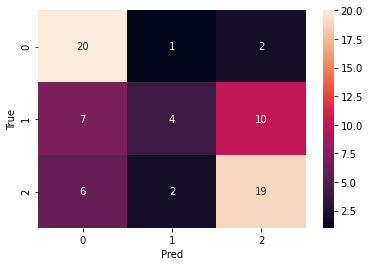

In [14]:
sns.heatmap(confusion_matrix(y_test_raw, y_test_pred), annot=True)
plt.ylabel('True')
plt.xlabel('Pred')
print('Confusion Matrix: \n')
plt.show()